In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('tulare_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93207,Tulare County,1,2015,Residential,123904.0,0.123904
1,93207,Tulare County,1,2015,Commercial,64787.0,0.064787
2,93208,Tulare County,1,2015,Residential,125562.0,0.125562
3,93218,Tulare County,1,2015,Residential,226018.0,0.226018
4,93219,Tulare County,1,2015,Residential,1061926.0,1.061926


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6768 entries, 0 to 6767
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        6768 non-null   int64  
 1   County         6768 non-null   object 
 2   Month          6768 non-null   int64  
 3   Year           6768 non-null   int64  
 4   CustomerClass  6768 non-null   object 
 5   TotalkWh       6768 non-null   float64
 6   TotalGWh       6768 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 370.3+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6768 entries, 0 to 6767
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        6768 non-null   int64         
 1   County         6768 non-null   object        
 2   Month          6768 non-null   int64         
 3   Year           6768 non-null   int64         
 4   CustomerClass  6768 non-null   object        
 5   TotalkWh       6768 non-null   float64       
 6   TotalGWh       6768 non-null   float64       
 7   Date           6768 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 423.1+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93207,Tulare County,1,2015,Residential,123904.0,0.123904
2015-01-01,93207,Tulare County,1,2015,Commercial,64787.0,0.064787
2015-01-01,93208,Tulare County,1,2015,Residential,125562.0,0.125562
2015-01-01,93218,Tulare County,1,2015,Residential,226018.0,0.226018
2015-01-01,93219,Tulare County,1,2015,Residential,1061926.0,1.061926


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,218694449.0,218.694449
2015-02-28,264397150.0,264.397150
2015-03-31,223204878.0,223.204878
2015-04-30,212383408.0,212.383408
2015-05-31,322296845.0,322.296845


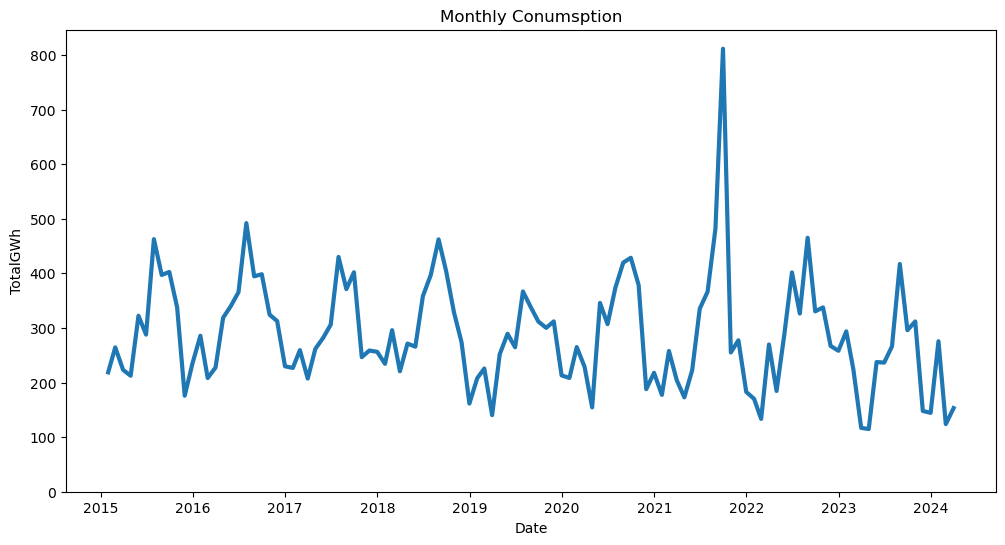

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.0790295615122434
p-value: 0.7233618191232973
Non-Stationary


***SARIMAX model can still handle non-stationary data***

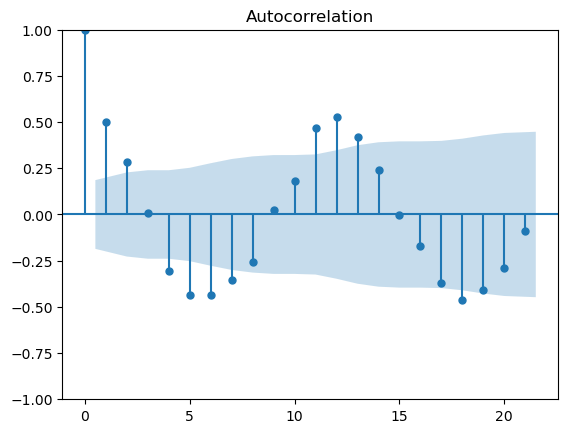

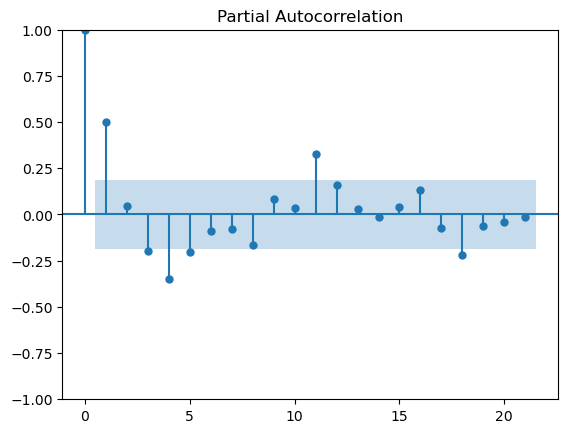

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1328.680, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1308.236, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1313.017, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1326.683, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1321.016, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1306.472, Time=0.40 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1298.748, Time=0.36 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1312.824, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1311.993, Time=0.30 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1325.537, Time=0.26 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

In [18]:
# p, d, q parameters
model.order

(2, 1, 0)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

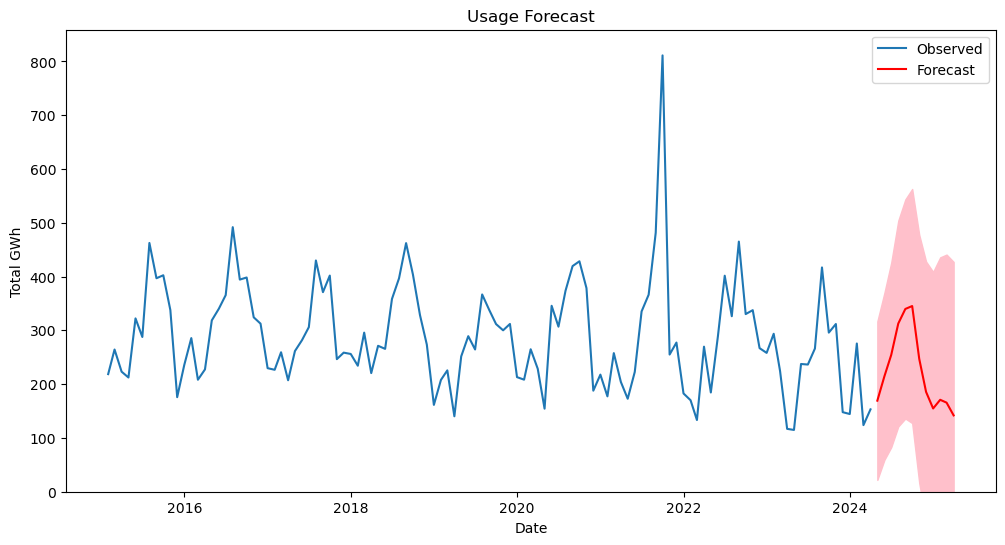

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

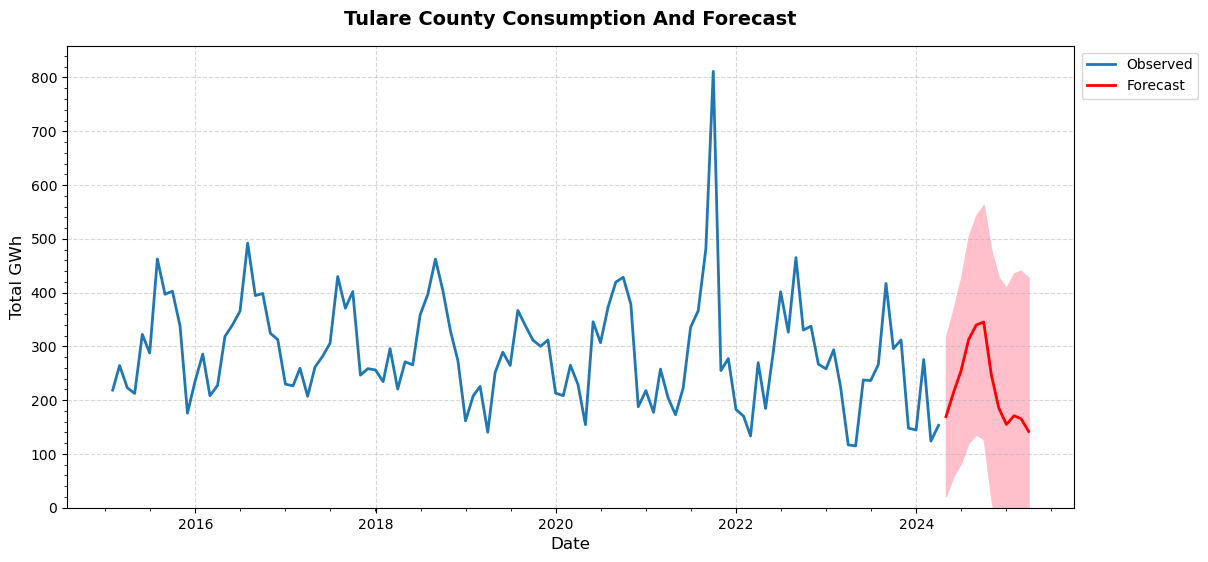

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(13, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Tulare County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.13,1), loc='upper right')

# Show plot
plt.savefig('tulare_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 44.912651224986014
MSE: 2744.470402914292
RMSE: 52.38769323910237


In [24]:
observed

Date
2023-04-30    114.883095
2023-05-31    237.492369
2023-06-30    236.478901
2023-07-31    266.210048
2023-08-31    417.030356
2023-09-30    295.853397
2023-10-31    311.857252
2023-11-30    147.923171
2023-12-31    144.473504
2024-01-31    275.591271
2024-02-29    123.848165
2024-03-31    153.147592
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30    169.309750
2024-05-31    214.523249
2024-06-30    254.360377
2024-07-31    312.752592
2024-08-31    339.845231
2024-09-30    345.275002
2024-10-31    247.001693
2024-11-30    185.608707
2024-12-31    154.798658
2025-01-31    170.941940
2025-02-28    165.654333
2025-03-31    141.944051
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

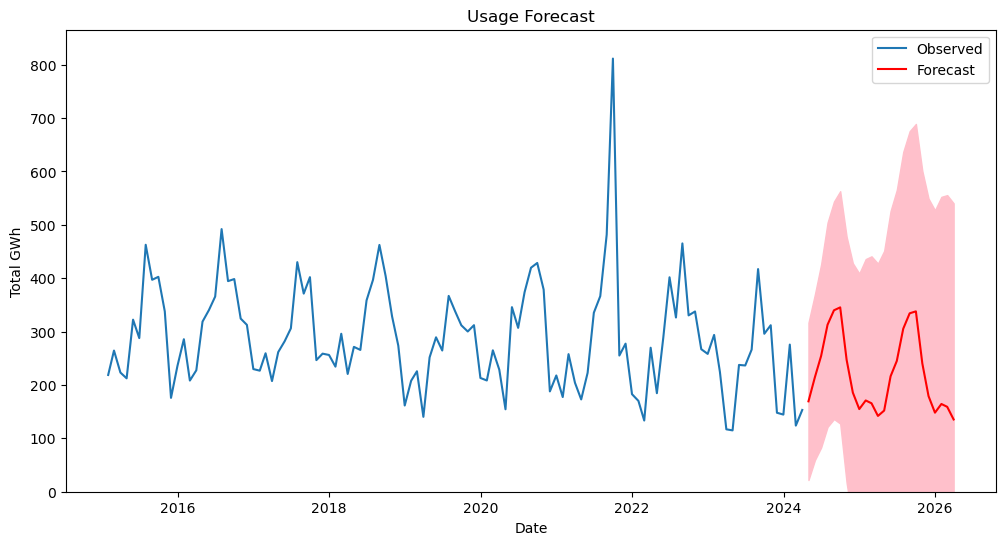

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 57.236730211204986
MSE: 5011.320050453213
RMSE: 70.790677708673


In [28]:
observed

Date
2022-04-30    184.543110
2022-05-31    288.864500
2022-06-30    401.651020
2022-07-31    326.336753
2022-08-31    465.101487
2022-09-30    330.304613
2022-10-31    337.569100
2022-11-30    266.963458
2022-12-31    258.148043
2023-01-31    293.692991
2023-02-28    224.305534
2023-03-31    116.900023
2023-04-30    114.883095
2023-05-31    237.492369
2023-06-30    236.478901
2023-07-31    266.210048
2023-08-31    417.030356
2023-09-30    295.853397
2023-10-31    311.857252
2023-11-30    147.923171
2023-12-31    144.473504
2024-01-31    275.591271
2024-02-29    123.848165
2024-03-31    153.147592
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30    169.309750
2024-05-31    214.523249
2024-06-30    254.360377
2024-07-31    312.752592
2024-08-31    339.845231
2024-09-30    345.275002
2024-10-31    247.001693
2024-11-30    185.608707
2024-12-31    154.798658
2025-01-31    170.941940
2025-02-28    165.654333
2025-03-31    141.944051
2025-04-30    151.994485
2025-05-31    216.282696
2025-06-30    245.004103
2025-07-31    305.306921
2025-08-31    334.190136
2025-09-30    337.833161
2025-10-31    240.345876
2025-11-30    179.076986
2025-12-31    148.073972
2026-01-31    164.336049
2026-02-28    159.027415
2026-03-31    135.323202
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural    8707.334347
Commercial      6732.377824
Industrial      6945.664550
Residential     9503.456093
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,8707.334347
1,Commercial,6732.377824
2,Industrial,6945.664550
3,Residential,9503.456093


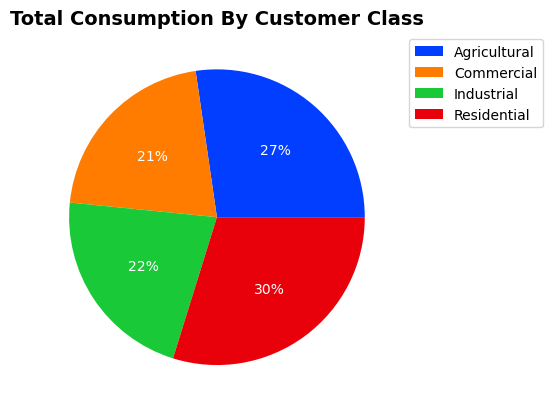

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

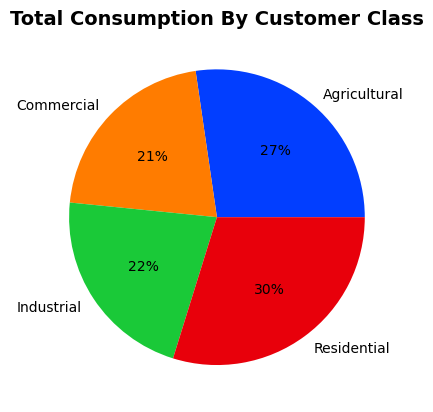

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

In [ ]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()